# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:

- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:

- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

**Обратите внимание:** *«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.*

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import math

import warnings

from pandas_profiling import ProfileReport

In [2]:
warnings.filterwarnings('ignore') 
%matplotlib inline

In [3]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [4]:
def df_info(df):
    df.info()
    display(df.head(10))
    print()
    print(f'Кол-во пропусков: {df.isnull().sum()}')
    print()
    print(f'Кол-во дубликатов: {df.duplicated().sum()}')

#### Звонки

In [5]:
df_info(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000



Кол-во пропусков: id           0
call_date    0
duration     0
user_id      0
dtype: int64

Кол-во дубликатов: 0


*Мы знаем, что оператор округляет минуты вверх. Проверим значения*

In [6]:
print(len(calls.query('duration < 1')))

47927


*47 927 данных, где длительность разговора была меньше 1 минуты*

*Во втором шаге нужно будет перевести 'call_date' к типу DateTime*
*Мы значем, что оператор округляет вверх значения минут, но почему-то 48 тыс данных имеют значения меньше 1*
*0-ые значения заменим на 1, а остальные данные округлим с помощью np.ceil*

#### Интернет

In [7]:
df_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000



Кол-во пропусков: Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Кол-во дубликатов: 0


*Мы знаем, что оператор округляет мегабайтов вверх. Проверим значения*

In [8]:
len(internet.query('mb_used < 1'))

19699

*Имеем 19 699 данных, где мб меньше 1 мегабайта*

*Тарифный план дается нам в гигабайтах. Скорее всего нужно будет перевести данные из мегабайтов в гигабайты для дальнейшего расчета*
*Дату сеанса также следует перевести к типу DateTime*
*Как и с звонками, нужно будет округлить числа с помощью np.ceil, а нулевые значения заменить на 1*

#### Сообщения

In [9]:
df_info(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000



Кол-во пропусков: id              0
message_date    0
user_id         0
dtype: int64

Кол-во дубликатов: 0


*Заменим тип данных 'messages_date' на DateTime во 2 шаге*

#### Тарифы

In [10]:
df_info(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



Кол-во пропусков: messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

Кол-во дубликатов: 0


*Пока что ничего необычного*

#### Пользователи

In [11]:
df_info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart



Кол-во пропусков: user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Кол-во дубликатов: 0


*Заменим название столбца 'tariff' на 'tariff_name'*

In [12]:
users = users.rename(columns = {'tariff' : 'tariff_name'})
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      500 non-null    int64 
 1   age          500 non-null    int64 
 2   churn_date   38 non-null     object
 3   city         500 non-null    object
 4   first_name   500 non-null    object
 5   last_name    500 non-null    object
 6   reg_date     500 non-null    object
 7   tariff_name  500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [13]:
users['tariff_name'].value_counts()

smart    351
ultra    149
Name: tariff_name, dtype: int64

*Известны следующие показатели:*
- *Из 500 пользователей, 462 все еще продолжают пользоваться услугами*
- *'reg_date' и 'churn_date' нужно будет перевести к DateTime*

### Вывод

*Особых нюансов не возникло, кроме типа данных в столбцах, где указана дата*
*Единственное за что можно зацепиться - почему имеются 0-ые значения и значения ниже 1, ведь Оператор округляет данные вверх. Либо это ошибка выгрузки данных, либо пора спрашивать коллег почему такое произошло и такие данные попались к нам*

### Шаг 2. Подготовьте данные

#### Исправим 0-ые значения и значения ниже 1

In [14]:
#Звонки
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'] = calls['duration'].replace(0, 1)

#Интернет
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].replace(0, 1)

#### Исправим тип данных в столбцах с датой

In [15]:
#Для упрощения создадим функцию по исправлению типа данных на DateTime и применим ее к нужным столбцам

dtformat = '%Y-%m-%d'

def to_datetime(data, columns):
    for column in columns:
        data[column] = pd.to_datetime(data[column], format = dtformat)

#Даты
to_datetime(calls, ['call_date'])
to_datetime(internet, ['session_date'])
to_datetime(messages, ['message_date'])
to_datetime(users, ['reg_date', 'churn_date'])

#Минуты и мегабайты
calls['duration'] = calls['duration'].astype('int64')
internet['mb_used'] = internet['mb_used'].astype('int64')

### Посчитайте для каждого пользователя:

In [16]:
# Функция для подсчета кол-ва операций
def sum(df, month, date, columns, value, aggfunc):
    df[month] = pd.DatetimeIndex(df[date]).month
    result = df.pivot_table(index = columns, values=value, aggfunc=aggfunc)
    return result

#### 1. Количество сделанных звонков и израсходованных минут разговора по месяцам

In [17]:
calls_by_month = sum(calls, 'month', 'call_date', ['month', 'user_id'], 'duration', ['count', 'sum'])

#### 2. Количество отправленных сообщений по месяцам

In [18]:
messages_by_month = sum(messages, 'month', 'message_date', ['month', 'user_id'], 'id', 'count')

#### 3. Объем израсходованного интернет-трафика по месяцам

In [19]:
internet_by_month = sum(internet, 'month', 'session_date', ['month', 'user_id'], 'mb_used', 'sum')

#### 4. Помесячная выручка с каждого пользователя

In [20]:
#Создадим датафрейм, в котором будет храниться вышерассчитанные значения
costs = pd.DataFrame()

#Создадим временный датасет и добавим в него данные по звонкам
tempory_data = pd.DataFrame(calls_by_month.to_records())

costs['user_id'] = tempory_data['user_id']
costs['month']   = tempory_data['month']
costs['calls']   = tempory_data.iloc[:, 2]
costs['minutes'] = tempory_data.iloc[:, 3]
#display(costs.head())

costs = costs.merge(messages_by_month, on=['user_id', 'month'], how='outer')
costs = costs.rename(columns={'id': 'messages'})
#display(costs.head())

costs = costs.merge(internet_by_month, on=['user_id', 'month'], how='outer')
costs.info()
display(costs.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   3214 non-null   int64  
 1   month     3214 non-null   int64  
 2   calls     3174 non-null   float64
 3   minutes   3174 non-null   float64
 4   messages  2717 non-null   float64
 5   mb_used   3203 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


,user_id,month,calls,minutes,messages,mb_used
0,1005,1,15.0,99.0,7.0,2730.0
1,1032,1,61.0,397.0,38.0,24158.0
2,1045,1,1.0,9.0,5.0,2348.0
3,1055,1,64.0,568.0,30.0,17115.0
4,1071,1,24.0,200.0,16.0,15625.0


*Видны пропуски в столбцах 'calls', 'minutes', 'messages' и 'mb_used'. Это говорит о том, что скорее всего клиенты пользовались не всеми функциями тарифа. Пропуски заменим на 0*
*Также сбились типы данных в столбцах 'calls', 'minutes', 'messages'. Типы данных изменились из-за наличия пропусков в столбцах. Нужно будет их перевести снова в инт*

In [21]:
#Заменим пропуски
costs['calls'] = costs['calls'].fillna(0)
costs['minutes'] = costs['minutes'].fillna(0)
costs['messages'] = costs['messages'].fillna(0)

#Исправим тип данных
costs['calls'] = costs['calls'].astype('int64')
costs['minutes'] = costs['minutes'].astype('int64')
costs['messages'] = costs['messages'].astype('int64')

In [22]:
df_info(costs)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   3214 non-null   int64  
 1   month     3214 non-null   int64  
 2   calls     3214 non-null   int64  
 3   minutes   3214 non-null   int64  
 4   messages  3214 non-null   int64  
 5   mb_used   3203 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 175.8 KB


,user_id,month,calls,minutes,messages,mb_used
0,1005,1,15,99,7,2730.0
1,1032,1,61,397,38,24158.0
2,1045,1,1,9,5,2348.0
3,1055,1,64,568,30,17115.0
4,1071,1,24,200,16,15625.0
5,1113,1,18,115,14,768.0
6,1120,1,5,56,0,657.0
7,1126,1,35,279,4,16378.0
8,1134,1,42,341,32,10218.0
9,1135,1,9,90,1,1602.0



Кол-во пропусков: user_id      0
month        0
calls        0
minutes      0
messages     0
mb_used     11
dtype: int64

Кол-во дубликатов: 0


*Добавим в датафрейм информацию о пользователях и тарифах*

In [23]:
costs = costs.merge(users, on='user_id', how='left').merge(tariffs, on='tariff_name', how='left')
display(costs.head())

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1005,1,15,99,7,2730.0,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3
1,1032,1,61,397,38,24158.0,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,50,15360,500,550,200,3,3
2,1045,1,1,9,5,2348.0,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,50,15360,500,550,200,3,3
3,1055,1,64,568,30,17115.0,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,50,15360,500,550,200,3,3
4,1071,1,24,200,16,15625.0,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,50,15360,500,550,200,3,3


*Перерасход минут, сообщений и трафика посчитаем как разность между месячным значением и включенным в тариф*

In [24]:
costs['minutes_over']  = costs['minutes'] - costs['minutes_included']
costs['messages_over'] = costs['messages'] - costs['messages_included']
costs['mb_used_over']  = costs['mb_used'] - costs['mb_per_month_included']

display(costs.head())

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over,messages_over,mb_used_over
0,1005,1,15,99,7,2730.0,67,NaT,Набережные Челны,Афанасий,...,50,15360,500,550,200,3,3,-401,-43,-12630.0
1,1032,1,61,397,38,24158.0,31,NaT,Ульяновск,Инна,...,50,15360,500,550,200,3,3,-103,-12,8798.0
2,1045,1,1,9,5,2348.0,48,NaT,Улан-Удэ,Джемма,...,50,15360,500,550,200,3,3,-491,-45,-13012.0
3,1055,1,64,568,30,17115.0,39,NaT,Казань,Луиза,...,50,15360,500,550,200,3,3,68,-20,1755.0
4,1071,1,24,200,16,15625.0,20,2018-08-31,Омск,Гектор,...,50,15360,500,550,200,3,3,-300,-34,265.0


*Если значение положительное, то идет перерасход, если отрицательное - тариф еще действует*

#### Вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана

In [25]:
def monthly_revenue(row):
    price_for_minutes = 0
    price_for_messages = 0
    price_per_mb_used = 0
    
    #Стоимость дополнительных минут
    if row['minutes_over'] > 0:
        price_for_minutes = row['minutes_over']  * row['rub_per_minute']
    
    #Стоимость дополнительных сообщений
    if row['messages_over'] > 0:
        price_per_messages = row['messages_over']  * row['rub_per_message']
        
    #Стоимость дополнительного трафика
    if row['mb_used_over'] > 0:
        price_per_mb_used = np.ceil(row['mb_used_over'] / 1024) * row['rub_per_gb']

    return price_for_minutes + price_for_messages + price_per_mb_used

In [26]:
costs['rub_monthly_fee_over'] = costs.apply(monthly_revenue, axis = 1)
costs['rub_monthly_fee_total'] = costs['rub_monthly_fee'] + costs['rub_monthly_fee_over']

display(costs.head())

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over,messages_over,mb_used_over,rub_monthly_fee_over,rub_monthly_fee_total
0,1005,1,15,99,7,2730.0,67,NaT,Набережные Челны,Афанасий,...,500,550,200,3,3,-401,-43,-12630.0,0.0,550.0
1,1032,1,61,397,38,24158.0,31,NaT,Ульяновск,Инна,...,500,550,200,3,3,-103,-12,8798.0,1800.0,2350.0
2,1045,1,1,9,5,2348.0,48,NaT,Улан-Удэ,Джемма,...,500,550,200,3,3,-491,-45,-13012.0,0.0,550.0
3,1055,1,64,568,30,17115.0,39,NaT,Казань,Луиза,...,500,550,200,3,3,68,-20,1755.0,604.0,1154.0
4,1071,1,24,200,16,15625.0,20,2018-08-31,Омск,Гектор,...,500,550,200,3,3,-300,-34,265.0,200.0,750.0


#### Оставим только необходимые значения

In [27]:
# Датафрейм только с нужными нами данными
costs = pd.DataFrame(costs[['month', 'tariff_name', 'user_id', 'city', 'calls', 'minutes', 'messages', 'mb_used', 'minutes_over', 'messages_over', 'mb_used_over', 'rub_monthly_fee', 'rub_monthly_fee_over', 'rub_monthly_fee_total']])
display(costs.head())

,month,tariff_name,user_id,city,calls,minutes,messages,mb_used,minutes_over,messages_over,mb_used_over,rub_monthly_fee,rub_monthly_fee_over,rub_monthly_fee_total
0,1,smart,1005,Набережные Челны,15,99,7,2730.0,-401,-43,-12630.0,550,0.0,550.0
1,1,smart,1032,Ульяновск,61,397,38,24158.0,-103,-12,8798.0,550,1800.0,2350.0
2,1,smart,1045,Улан-Удэ,1,9,5,2348.0,-491,-45,-13012.0,550,0.0,550.0
3,1,smart,1055,Казань,64,568,30,17115.0,68,-20,1755.0,550,604.0,1154.0
4,1,smart,1071,Омск,24,200,16,15625.0,-300,-34,265.0,550,200.0,750.0


In [28]:
print(len(costs.groupby('user_id')))

498


*Нет информации по расходам по 2-ум пользователям*

*Проверим сколько приходиться пользователей на каждый тариф*

In [29]:
#Тариф "Смарт"
smart_costs = costs.query("tariff_name == 'smart'")
print('Кол-во клиентов, которые используют тариф "Смарт": {}'.format(len(smart_costs.groupby('user_id'))))

#Тариф "Ультра"
ultra_costs = costs.query("tariff_name == 'ultra'")
print('Кол-во клиентов, которые используют тариф "Ультра": {}'.format(len(ultra_costs.groupby('user_id'))))

Кол-во клиентов, которые используют тариф "Смарт": 350
Кол-во клиентов, которые используют тариф "Ультра": 148


### Вывод

*Данные были подсчитаны и добавлены.*

*Подсчет вывел, что 350 пользователей используют тариф "Смарт", 148 клиентов ипользуют тариф "Ультра". Касательно отсутствия данных по 2 клиентам, скорее всего нужно запрашивать информацию у коллег*

### Шаг 3. Проанализируйте данные

**Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения**

In [30]:
# Функция для создания сводной таблицы
def monthly_tariff_costs(df, tariff):
    monthly_tariff_costs = df.query('tariff_name == @tariff').pivot_table(index=['tariff_name', 'month'], values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total'])
    display(monthly_tariff_costs)

In [31]:
monthly_smart_costs = monthly_tariff_costs(costs, "smart")
monthly_ultra_costs = monthly_tariff_costs(costs, "ultra")

mb_used   messages     minutes  rub_monthly_fee_over  \
tariff_name month                                                              
smart       1       8528.588235  18.235294  209.647059            171.235294   
            2      11617.344828  24.086207  306.310345            279.517241   
            3      15131.207792  31.857143  400.532468            613.532468   
            4      13486.080357  30.741071  377.000000            413.866071   
            5      15832.751773  33.773050  398.404255            653.063830   
            6      15822.445122  33.402439  406.701220            657.134146   
            7      15771.398010  33.751244  419.288557            679.114428   
            8      16711.324786  33.638298  433.191489            778.208511   
            9      16332.615385  33.638462  440.080769            707.446154   
            10     16786.853741  33.765306  438.295918            820.853741   
            11     16925.962025  34.075949  447.620253            798.531646   
            12     18145.824926  35.994065  491.418398           1033.801187   

                   rub_monthly_fee_total  
tariff_name month                         
smart       1                 721.235294  
            2                 829.517241  
            3                1163.532468  
            4                 963.866071  
            5                1203.063830  
            6                1207.134146  
            7                1229.114428  
            8                1328.208511  
            9                1257.446154  
            10               1370.853741  
            11               1348.531646  
            12               1583.801187

mb_used   messages     minutes  rub_monthly_fee_over  \
tariff_name month                                                              
ultra       1      13154.666667  33.777778  440.888889              0.000000   
            2      12860.000000  21.958333  304.666667             25.000000   
            3      17553.513514  32.297297  503.081081             64.864865   
            4      16845.254545  31.563636  470.072727             51.818182   
            5      19676.878788  37.850746  524.865672            111.940299   
            6      19172.168675  41.726190  492.428571             91.071429   
            7      20744.533333  49.846154  560.296703            171.428571   
            8      19780.745283  48.439252  524.570093            133.177570   
            9      19392.675439  52.286957  553.643478             74.347826   
            10     20230.008197  58.430894  572.829268            117.073171   
            11     19956.052632  55.791045  555.805970            143.283582   
            12     21973.768116  60.611511  609.129496            188.848921   

                   rub_monthly_fee_total  
tariff_name month                         
ultra       1                1950.000000  
            2                1975.000000  
            3                2014.864865  
            4                2001.818182  
            5                2061.940299  
            6                2041.071429  
            7                2121.428571  
            8                2083.177570  
            9                2024.347826  
            10               2067.073171  
            11               2093.283582  
            12               2138.848921

*У пользователей с тарифом "Ультра" перерасход не прям большой по сравнению с клиентами, которые пользуются тарифом "Смарт"*

In [32]:
def multiple_graph(df, tariff1="smart", tariff2="ultra"):
    smart_graph = df.query('tariff_name == @tariff1').pivot_table(index = 'month', values = 'rub_monthly_fee_total')
    ultra_graph = df.query('tariff_name == @tariff2').pivot_table(index = 'month', values = 'rub_monthly_fee_total')
    
    plt.figure(figsize = (12, 6))
    plt.title('Ср. выручка с клиента по тарифу', fontsize=16)
    plt.plot(smart_graph, marker='o', label = tariff1)
    plt.plot(ultra_graph, marker='o', label = tariff2)
    plt.xlabel('Месяц')
    plt.ylabel('Ср. выручка с клиента')
    plt.legend(loc='lower right')
    plt.grid()

    plt.show()

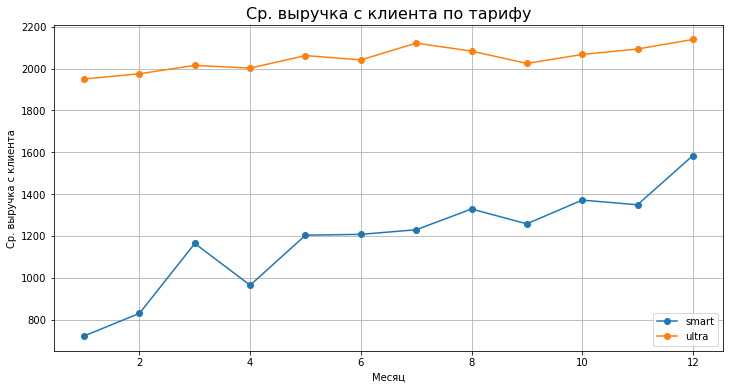

In [33]:
multiple_graph(costs)

*Как видно, график тоже подтверждает разницу между ср. выручки с клиента в зависимости от тарифа. Также можно наблюдать, что в течение года было замечено равномерное увеличение выручки с клиентов, которые использовали тариф "Смарт"*

*Возможно скоро они перейдут с тарифа "Смарта" на "Ультра"*

#### Минуты разговора, количество сообщений и объём интернет-трафика в среднем необходимые пользователям каждого тарифа в месяц

In [34]:
usage_mean = costs.pivot_table(index='tariff_name', values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total'])
display(usage_mean)
print()

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
tariff_name,,,,,
smart,16244.472172,33.384029,429.450875,745.112607,1295.112607
ultra,19688.587692,49.363452,540.779695,121.065990,2071.065990


*Результат показал, что в среднем пользователи тарифа "Смарт" переплачивают за тариф из-за перерасходов. Отсюда можно сделать вывод, что если имеются тарифы между "Смарт" и "Ультра", то клиентам, которые обычно перерасходывают свои тарифы, следовала бы перейти на другой тариф. Найти некую золотую середину для своих потребностей.*

### Составим портреты пользователей

In [35]:
def hist(df1, df2, column, title, bins):
    plt.title(title, fontsize=16)
    df1[column].plot(kind = 'hist', grid = True, figsize = (12, 6), label = 'Smart', alpha=0.75, bins=bins)
    df2[column].plot(kind = 'hist', grid = True, label = 'Ultra', alpha=0.75, bins=bins)
    plt.legend(loc='right')

#### Сколько в среднем трятят минут в зависимости от тарифа

In [36]:
#Ср. значения для клиентов, которые используют тариф "Смарт"
smart_usage_mean = costs.query('tariff_name == "smart"').pivot_table(index=['user_id', 'month'], values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total'])

#Ср. значения для клиентов, которые используют тариф "Ультра"
ultra_usage_mean = costs.query('tariff_name == "ultra"').pivot_table(index=['user_id', 'month'], values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total'])

In [37]:
smart_usage_mean['minutes'].describe()

count    2229.000000
mean      429.450875
std       194.871174
min         0.000000
25%       291.000000
50%       435.000000
75%       560.000000
max      1471.000000
Name: minutes, dtype: float64

In [38]:
ultra_usage_mean['minutes'].describe()

count     985.000000
mean      540.779695
std       325.738740
min         0.000000
25%       292.000000
50%       532.000000
75%       773.000000
max      1727.000000
Name: minutes, dtype: float64

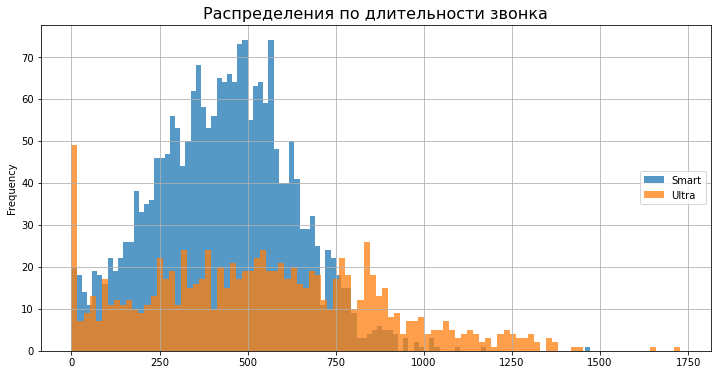

In [39]:
hist(smart_usage_mean, ultra_usage_mean, 'minutes', 'Распределения по длительности звонка', 100)

*У клиентов, которые используют тариф "Смарт", наблюдается нормальное распределение, а у клиентов тарифа "Ультра" - распределение Пуассона*

*Также можно заметить, что в среднем клиенты тарифа "Смарт" на разговор в месяц тратят 429 минут, что не доходит до порогового значения (500 минут). В свою очередь, клиенты  тарифа "Ультра" в среднем в месяц на разговор тратят 540 минут, хотя в их тариф включено 3000 минут (Да что уж там, макс значение всего 1727 минут)*

#### Сколько в среднем отправляют сообщений в зависимости от тарифа

In [40]:
smart_usage_mean['messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

In [41]:
ultra_usage_mean['messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

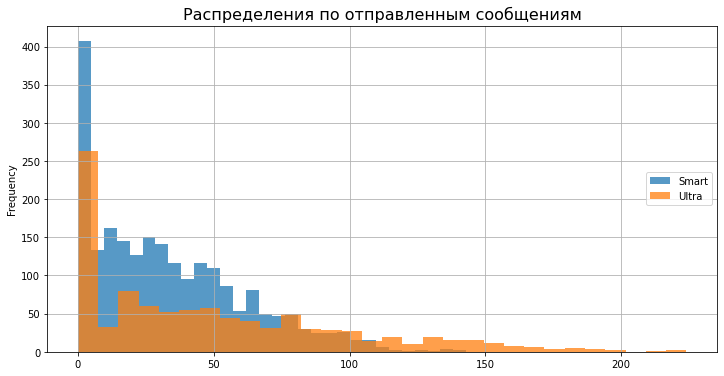

In [42]:
hist(smart_usage_mean, ultra_usage_mean, 'messages', 'Распределения по отправленным сообщениям', 30)

*Оба распределениям являются Пуассановским*

*Результат показал, что в среднем в месяц клиенты тарифа "Смарт" отправляют 33 сообщения, что входит в порог планого тарифа. А вот клиенты тарифа "Ультра" в среднем отправляют 49 сообщений, хотя для их тарифа предусмотренно 1000 сообщений*

#### Сколько в среднем трятят объям интернет-трафика в зависимости от тарифа

In [43]:
smart_usage_mean['mb_used'].describe()

count     2228.000000
mean     16244.472172
std       5871.037024
min          1.000000
25%      12673.250000
50%      16541.500000
75%      20078.750000
max      38627.000000
Name: mb_used, dtype: float64

In [44]:
ultra_usage_mean['mb_used'].describe()

count      975.000000
mean     19688.587692
std       9952.830482
min          1.000000
25%      12022.000000
50%      19416.000000
75%      26921.500000
max      49793.000000
Name: mb_used, dtype: float64

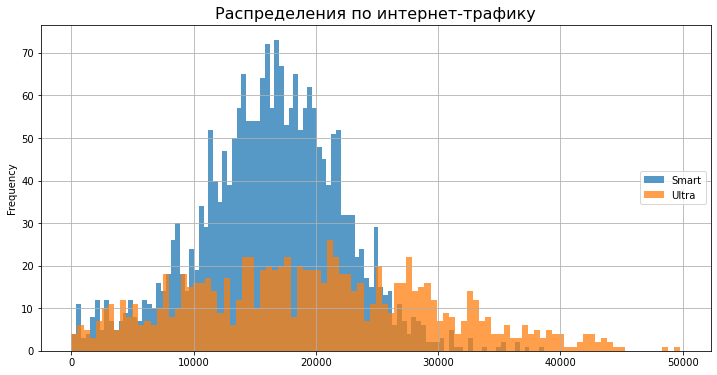

In [45]:
hist(smart_usage_mean, ultra_usage_mean, 'mb_used', 'Распределения по интернет-трафику', 100)

*Оба распределения являются нормальными*

*В среднем в месяц клиент тарифа "Смарт" перерасходывает тарифный план на 0,86 гб. А клиенты тарифа "Ультра" наоборот тратят всего 19 гб, хотя в их плане доступно 30 гб*

#### Средняя выручка с клиентов в зависимости от тарифа

In [46]:
smart_usage_mean['rub_monthly_fee_total'].describe()

count    2229.000000
mean     1295.112607
std       826.045164
min       550.000000
25%       550.000000
50%      1045.000000
75%      1750.000000
max      6725.000000
Name: rub_monthly_fee_total, dtype: float64

In [47]:
ultra_usage_mean['rub_monthly_fee_total'].describe()

count     985.000000
mean     2071.065990
std       378.802377
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: rub_monthly_fee_total, dtype: float64

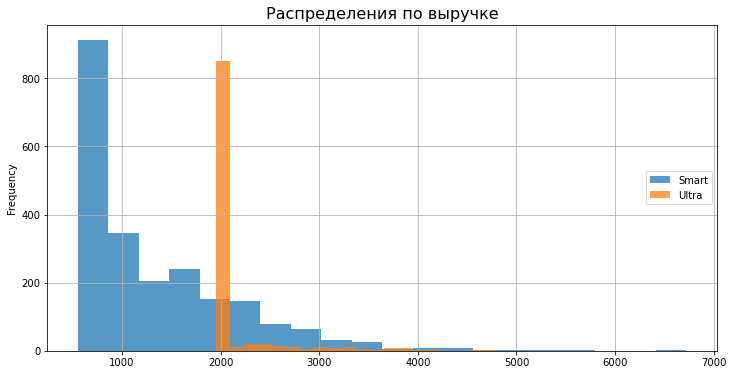

In [48]:
hist(smart_usage_mean, ultra_usage_mean, 'rub_monthly_fee_total', 'Распределения по выручке', 20)

*Можно видеть ну очень аномальные значения у клиентов тарифа "Смарт". Макс значение по оплате тарифа составило 6725, хотя тарифный план стоит 550!!!. У клиентов тарифа "Ультра" разница не такая большая, при плане в 1950, макс значение составило 4800*

*В среднем в месяц 1 клиент тарифа "Смарт" приносит оператору 1295 у.е., а клиент тарифа "Ультра" - 2071 у.е.*

#### Дисперсия и стандартное отклонение

***Дисперсия** - это мера разброса возможных исходов относительно ожидаемого значения. Следовательно, чем выше дисперсия, тем больше разброс*

***Среднее квадратическое отклонение** так же, как и среднее линейное отклонение, показывает, на сколько в среднем отклоняются конкретные значения признака от среднего их значения. Среднее квадратическое отклонение всегда больше среднего линейного отклонения.*

In [49]:
def var(df1, df2, column):
    smart_minutes_var = np.var(df1[column], ddof=1)
    ultra_minutes_var = np.var(df2[column], ddof=1)

    print('Дисперсия (минуты разговора) по тарифу "Смарт": {}'.format(round(smart_minutes_var, 2)))
    print('Дисперсия (минуты разговора) по тарифу "Ультра": {}'.format(round(ultra_minutes_var, 2)))
    return smart_minutes_var, ultra_minutes_var

#### Минуты разговора

In [50]:
#Смарт
smart_costs['minutes'].describe()

count    2229.000000
mean      429.450875
std       194.871174
min         0.000000
25%       291.000000
50%       435.000000
75%       560.000000
max      1471.000000
Name: minutes, dtype: float64

In [51]:
#Ультра
ultra_costs['minutes'].describe()

count     985.000000
mean      540.779695
std       325.738740
min         0.000000
25%       292.000000
50%       532.000000
75%       773.000000
max      1727.000000
Name: minutes, dtype: float64

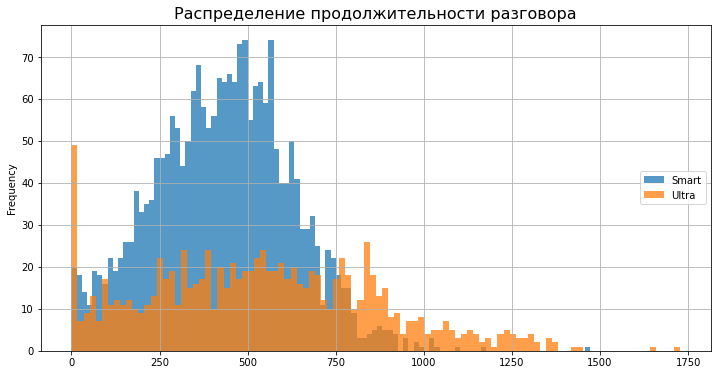

In [52]:
hist(smart_costs, ultra_costs, 'minutes', 'Распределение продолжительности разговора', 100)

In [53]:
smart_minutes_var, ultra_minutes_var = var(smart_costs, ultra_costs, 'minutes')

Дисперсия (минуты разговора) по тарифу "Смарт": 37974.77
Дисперсия (минуты разговора) по тарифу "Ультра": 106105.73


In [54]:
temporary_result = {'Тариф' : ['Смарт', 'Ультра'], 'Стандартное отклонение' : [np.std(smart_costs['minutes'], ddof=1), np.std(ultra_costs['minutes'], ddof=1)], 'Дисперсия' : [smart_minutes_var, ultra_minutes_var]}

result = pd.DataFrame(temporary_result)
display(round(result, 2))

,Тариф,Стандартное отклонение,Дисперсия
0,Смарт,194.87,37974.77
1,Ультра,325.74,106105.73


#### Количество сообщений

In [55]:
#Смарт
smart_costs['messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

In [56]:
#Ультра
ultra_costs['messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

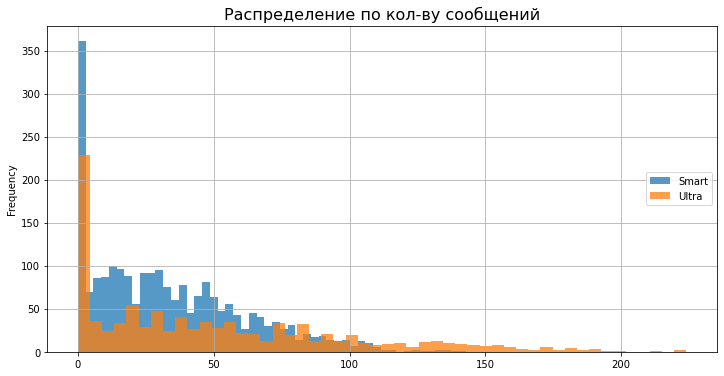

In [57]:
hist(smart_costs, ultra_costs, 'messages', 'Распределение по кол-ву сообщений', 50)

In [58]:
smart_messages_var, ultra_messages_var = var(smart_costs, ultra_costs, 'messages')

Дисперсия (минуты разговора) по тарифу "Смарт": 796.81
Дисперсия (минуты разговора) по тарифу "Ультра": 2285.27


In [59]:
temporary_result = {'Тариф' : ['Смарт', 'Ультра'], 'Стандартное отклонение' : [np.std(smart_costs['messages'], ddof=1), np.std(ultra_costs['messages'], ddof=1)], 'Дисперсия' : [smart_messages_var, ultra_messages_var]}

result = pd.DataFrame(temporary_result)
display(result)

,Тариф,Стандартное отклонение,Дисперсия
0,Смарт,28.227876,796.812958
1,Ультра,47.804457,2285.266143


#### Интернет-трафик

In [60]:
#Смарт
smart_costs['mb_used'].describe()

count     2228.000000
mean     16244.472172
std       5871.037024
min          1.000000
25%      12673.250000
50%      16541.500000
75%      20078.750000
max      38627.000000
Name: mb_used, dtype: float64

In [61]:
#Ультра
ultra_costs['mb_used'].describe()

count      975.000000
mean     19688.587692
std       9952.830482
min          1.000000
25%      12022.000000
50%      19416.000000
75%      26921.500000
max      49793.000000
Name: mb_used, dtype: float64

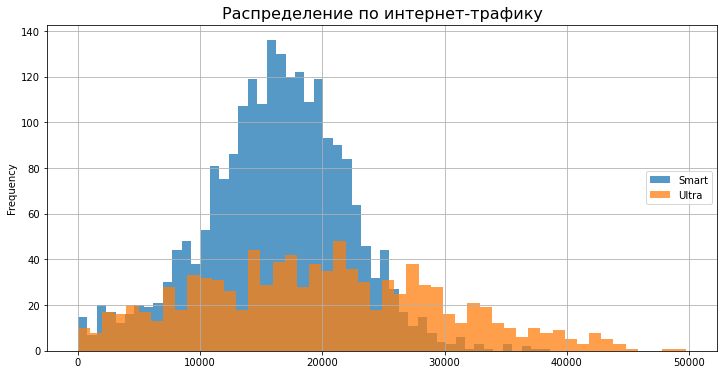

In [62]:
hist(smart_costs, ultra_costs, 'mb_used', 'Распределение по интернет-трафику', 50)

In [63]:
smart_mb_used_var, ultra_mb_used_var = var(smart_costs, ultra_costs, 'mb_used')

Дисперсия (минуты разговора) по тарифу "Смарт": 34469075.74
Дисперсия (минуты разговора) по тарифу "Ультра": 99058834.61


In [64]:
temporary_result = {'Тариф' : ['Смарт', 'Ультра'], 'Стандартное отклонение' : [np.std(smart_costs['mb_used'], ddof=1), np.std(ultra_costs['mb_used'], ddof=1)], 'Дисперсия' : [smart_mb_used_var, smart_mb_used_var]}

result = pd.DataFrame(temporary_result)
display(result)

,Тариф,Стандартное отклонение,Дисперсия
0,Смарт,5871.037024,3.446908e+07
1,Ультра,9952.830482,3.446908e+07


#### Вывод

*На мой взгляд данные оказались "шумными" из-за большого разброса, тому есть подтверждение - большое значение дисперсии. Также стандартное отклонение было немалым относительно среднего значения данных*

### Шаг 4. Проверьте гипотезы

#### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [65]:
print('Средная выручка пользователей тарифов:')
print('--------------------------------------')
print(usage_mean['rub_monthly_fee_total'])

Средная выручка пользователей тарифов:
--------------------------------------
tariff_name
smart    1295.112607
ultra    2071.065990
Name: rub_monthly_fee_total, dtype: float64


**Нулевая гипотеза:**
    - *Средняя выручка пользователей тарифов "Ультра" и "Смарт" не различается*

**Альтернативная гипотеза:**
    - *Средняя выручка пользователей тарифов "Ультра" и "Смарт" различается*

*Пороговое значение alpha зададим 0.05 (5%)*

In [66]:
alpha = .05

results = st.ttest_ind(smart_costs['rub_monthly_fee_total'], ultra_costs['rub_monthly_fee_total'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6792415134898723e-156
Отвергаем нулевую гипотезу


*Средняя выручка по тарифам не одинакова, нулевая вероятность говорит о том, что случайно получить различие в значениях не получится. Следовательно, средняя выручка пользователей тарифов "Ультра" и "Смарт" различается и наша гипотеза подтвердилась*

#### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [67]:
#Создадим датафрейм по запросу
moscow_df = costs['city'] == 'Москва'
costs['city'].where(moscow_df, 'Другой регион', inplace = True)

city_monthly_costs = costs.pivot_table(index = ['city', 'month'], values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total'])

city_usage = city_monthly_costs.pivot_table(index = 'city', values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total'])

display(city_usage)

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
city,,,,,
Другой регион,15758.440143,35.268458,424.594742,480.228268,1426.768316
Москва,17603.175813,33.944639,455.792652,422.373070,1517.338340


*Особо ощущимых различий нет. Видно только то, что в москве в среднем на 2гб тратят больше, чем в других регионах, также звони длятся на 30 мин больше, а сообщений на 1 меньше. По затратам тоже большого различия нет*

In [68]:
print('Средная выручка пользователей тарифов: {}'.format(city_usage['rub_monthly_fee_total']))

Средная выручка пользователей тарифов: city
Другой регион    1426.768316
Москва           1517.338340
Name: rub_monthly_fee_total, dtype: float64


**Нулевая гипотеза:**
    - *Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов*

**Альтернативная гипотеза:**
    - *Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов*

*Пороговое значение alpha зададим 0.05 (5%)*

In [69]:
moscow_costs = costs.query("city == 'Москва'")['rub_monthly_fee_total']
other_cities_costs = costs.query("city == 'Другой регион'")['rub_monthly_fee_total']

results = st.ttest_ind(moscow_costs, other_cities_costs)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.47775651271321995
Не получилось отвергнуть нулевую гипотезу


*Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из Москвы и регионов неодинакова, с вероятностью в 42% такое различие можно получить случайно. Как мы уже знаем, это большая вероятность, чтобы делать вывод о значимом различии между средними выручками. Таким образом, средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, и гипотеза не подтвердилась.*

### Шаг 5. Напишите общий вывод

1. **Шаг 1. Откройте файл с данными и изучите общую информацию.**
*Особых нюансов не возникло, кроме типа данных в столбцах, где указана дата. Нужно было поменять тип данных на DateTime*
*Единственное за что можно зацепиться - почему имеются 0-ые значения и значения ниже 1, ведь Оператор округляет данные вверх. Либо это ошибка выгрузки данных, либо пора спрашивать коллег почему такое произошло и как такие данные попались к нам*

2. **Шаг 2. Подготовьте данные**
*Данные были подсчитаны и добавлены.*

*Подсчет вывел, что 350 пользователей используют тариф "Смарт", 148 клиентов ипользуют тариф "Ультра". Касательно отсутствия данных по 2 клиентам, скорее всего нужно запрашивать информацию у коллег*

3. **Шаг 3. Проанализируйте данные**
    - 1. *Минуты разговора, количество сообщений и объём интернет-трафика в среднем необходимые пользователям каждого тарифа в месяц*
        - *Результат показал, что в среднем пользователи тарифа "Смарт" переплачивают за тариф из-за перерасходов. Отсюда можно сделать вывод, что если имеются тарифы между "Смарт" и "Ультра", то клиентам, которые обычно перерасходывают свои тарифы, следовала бы перейти на другой тариф. Найти некую золотую середину для своих потребностей. Хотя можно сделать вывод, что все же тариф "Смарт" наиболее выгоден клиентам, так как он не тратит такие средства, как если бы использовал тариф "Ультра"*
        - *Если судить по выручки, то понятно, что дохода больше приходит с клиентов, которые используют тариф "Ультра"*

    - 2. *Дисперсия и стандартное отклонение*
        - *Расчеты были проведены. На мой взгляд данные оказались "шумными" из-за большого разброса, тому есть подтверждение - большое значение дисперсии. Также стандартное отклонение было немалым относительно среднего значения данных*

4. **Шаг 4. Проверьте гипотезы**
    - 1. *Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается*
        - *Средняя выручка по тарифам не одинакова, нулевая вероятность говорит о том, что случайно получить различие в значениях не получится. Следовательно, средняя выручка пользователей тарифов "Ультра" и "Смарт" различается и наша гипотеза подтвердилась*
    - 2. *Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов*
        - *Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из Москвы и регионов неодинакова, с вероятностью в 42% такое различие можно получить случайно. Как мы уже знаем, это большая вероятность, чтобы делать вывод о значимом различии между средними выручками. Таким образом, средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, и гипотеза не подтвердилась.*